<a href="https://colab.research.google.com/github/GuilhermeDS-ML/Predict_Stock/blob/main/Predict_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and load data

In [1]:
pip install prophet

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pyarrow as pa
import pyarrow.parquet as pq

from datetime import date, datetime, timedelta, time

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

import scipy
import statsmodels.api as sm
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from math import sqrt

from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Function to identify null values
def nulls(df):
    length = df.shape[0]
    cols_null = df.columns[df.isnull().sum() > 0]
    return df.loc[:, cols_null].isnull().sum().to_frame('values_missing').assign(rate=lambda x: (x / length) * 100).reset_index().rename(columns={'index': 'cols'})

In [4]:
df = pq.ParquetFile('/content/bbas3.parquet').read().to_pandas()

In [5]:
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [6]:
df = df['close']

In [7]:
df

,close
time,
2024-10-04,26.86
2024-10-03,26.90
2024-10-02,27.15
2024-10-01,27.08
2024-09-30,27.18
...,...
2021-01-08,14.58
2021-01-07,14.49
2021-01-06,13.92


In [8]:
df.isnull().sum()

0

In [9]:
df2 = pq.ParquetFile('/content/bbse3.parquet').read().to_pandas()

df2['time'] = pd.to_datetime(df2['time'])
df2.set_index('time', inplace=True)

df2 = df2['close']

In [10]:
df2

,close
time,
2024-10-04,35.08
2024-10-03,35.12
2024-10-02,35.46
2024-10-01,35.75
2024-09-30,35.50
...,...
2021-01-08,22.29
2021-01-07,21.62
2021-01-06,21.17


In [11]:
df2.isnull().sum()

0

In [12]:
df.shape, df2.shape

((939,), (939,))

In [13]:
df2.name = 'bbse3'

In [14]:
# Dollar price
df3 = pq.ParquetFile('/content/usd_brl.parquet').read().to_pandas()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 976 entries, 7 to 982
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      976 non-null    object        
 1   Último    976 non-null    object        
 2   Abertura  976 non-null    object        
 3   Máxima    976 non-null    object        
 4   Mínima    976 non-null    object        
 5   Vol.      525 non-null    object        
 6   Var%      976 non-null    object        
 7   time      976 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(7)
memory usage: 68.6+ KB


In [15]:
df3

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,time
7,04.10.2024,"5,4555","5,4778","5,5199","5,4513",None,"-0,37%",2024-10-04
8,03.10.2024,"5,4759","5,4417","5,5116","5,4385",None,"0,65%",2024-10-03
9,02.10.2024,"5,4407","5,4377","5,4608","5,4037",None,"0,07%",2024-10-02
10,01.10.2024,"5,4368","5,4500","5,4788","5,4296",None,"-0,21%",2024-10-01
11,30.09.2024,"5,4482","5,4347","5,4740","5,4025",None,"0,28%",2024-09-30
...,...,...,...,...,...,...,...,...
978,07.01.2021,"5,4101","5,3169","5,4187","5,2989","169,63K","1,81%",2021-01-07
979,06.01.2021,"5,3139","5,2863","5,3597","5,2318","225,65K","0,54%",2021-01-06
980,05.01.2021,"5,2854","5,2955","5,3547","5,2515","179,01K","-0,22%",2021-01-05
981,04.01.2021,"5,2968","5,1351","5,2972","5,1197","163,79K","1,98%",2021-01-04


In [16]:
df3.set_index('time', inplace=True)

df3['usd_brl'] = df3['Último'].replace(',', '.', regex=True).astype(float)
df3 = df3['usd_brl']

In [17]:
df3

,usd_brl
time,
2024-10-04,5.4555
2024-10-03,5.4759
2024-10-02,5.4407
2024-10-01,5.4368
2024-09-30,5.4482
...,...
2021-01-07,5.4101
2021-01-06,5.3139
2021-01-05,5.2854


In [18]:
obs = [x for x in df3.index if x not in df.index]

In [19]:
df3[obs]

,usd_brl
time,
2024-05-30,5.2034
2024-05-01,5.1936
2024-03-29,5.0153
2024-02-13,4.9536
2024-02-12,4.9536
2024-01-01,4.8526
2023-11-15,4.8620
2023-10-12,5.0460
2023-09-07,4.9767


- We can see that the difference lies in holidays and days when the stock market is not operating.

In [20]:
# Gold price
df4 = pq.ParquetFile('/content/gold_usd.parquet').read().to_pandas()

In [21]:
df4.set_index('time', inplace=True)

df4['gold_usd'] = df4['Último'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
df4 = df4['gold_usd']

In [22]:
df4

,gold_usd
time,
2024-10-04,2652.25
2024-10-03,2655.90
2024-10-02,2657.75
2024-10-01,2662.82
2024-09-30,2634.49
...,...
2021-01-07,1912.50
2021-01-06,1918.81
2021-01-05,1949.35


In [23]:
df = pd.concat([df, df2, df3, df4], axis=1, join='inner')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 939 entries, 2024-10-04 to 2021-01-04
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   close     939 non-null    float64
 1   bbse3     939 non-null    float64
 2   usd_brl   939 non-null    float64
 3   gold_usd  939 non-null    float64
dtypes: float64(4)
memory usage: 36.7 KB


In [25]:
df.shape

(939, 4)

# Prepare data

The BBSE3 stock will be used as an exogenous variable. Therefore, I chose to use the values from the previous period.

In other words, to predict the next week, we will use the values from the current week.

For this, we will advance the BBSE3 values by 5 lags.

In [26]:
df['bbse3_lag'] = df['bbse3'].shift(-5)
df['usd_brl_lag'] = df['usd_brl'].shift(-5)
df['gold_usd_lag'] = df['gold_usd'].shift(-5)
df.dropna(inplace=True)

In [27]:
df.head(7)

,close,bbse3,usd_brl,gold_usd,bbse3_lag,usd_brl_lag,gold_usd_lag
time,,,,,,,
2024-10-04,26.86,35.08,5.4555,2652.25,35.37,5.4329,2657.97
2024-10-03,26.90,35.12,5.4759,2655.90,35.47,5.4375,2670.20
2024-10-02,27.15,35.46,5.4407,2657.75,35.35,5.4774,2656.82
2024-10-01,27.08,35.75,5.4368,2662.82,35.42,5.4547,2656.70
2024-09-30,27.18,35.50,5.4482,2634.49,35.13,5.5364,2628.40
2024-09-27,27.25,35.37,5.4329,2657.97,35.01,5.5103,2621.96
2024-09-26,27.48,35.47,5.4375,2670.20,35.36,5.4263,2586.48


In [28]:
df.shape

(934, 7)

In [29]:
df[df.index.duplicated(keep=False)]

,close,bbse3,usd_brl,gold_usd,bbse3_lag,usd_brl_lag,gold_usd_lag
time,,,,,,,


In [30]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [31]:
df.drop(['bbse3', 'usd_brl', 'gold_usd'], axis=1, inplace=True)

In [32]:
cols = df.drop('close', axis=1).columns.to_list()
cols

['bbse3_lag', 'usd_brl_lag', 'gold_usd_lag']

## Overview

Let's see if the test demonstrates any 'causality' between the target variable and the exogenous ones.

In [33]:
from statsmodels.tsa.stattools import grangercausalitytests

In [34]:
maxlag = 5
test_causality = grangercausalitytests(df[['close', 'bbse3_lag']], maxlag=maxlag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3642  , p=0.0370  , df_denom=930, df_num=1
ssr based chi2 test:   chi2=4.3783  , p=0.0364  , df=1
likelihood ratio test: chi2=4.3681  , p=0.0366  , df=1
parameter F test:         F=4.3642  , p=0.0370  , df_denom=930, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2643  , p=0.1045  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=4.5530  , p=0.1026  , df=2
likelihood ratio test: chi2=4.5420  , p=0.1032  , df=2
parameter F test:         F=2.2643  , p=0.1045  , df_denom=927, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3809  , p=0.2472  , df_denom=924, df_num=3
ssr based chi2 test:   chi2=4.1740  , p=0.2433  , df=3
likelihood ratio test: chi2=4.1647  , p=0.2442  , df=3
parameter F test:         F=1.3809  , p=0.2472  , df_denom=924, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1346  , p=0.3388  

In [35]:
test_causality = grangercausalitytests(df[['close', 'usd_brl_lag']], maxlag=maxlag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6688  , p=0.4137  , df_denom=930, df_num=1
ssr based chi2 test:   chi2=0.6710  , p=0.4127  , df=1
likelihood ratio test: chi2=0.6707  , p=0.4128  , df=1
parameter F test:         F=0.6688  , p=0.4137  , df_denom=930, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3295  , p=0.2651  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=2.6733  , p=0.2627  , df=2
likelihood ratio test: chi2=2.6695  , p=0.2632  , df=2
parameter F test:         F=1.3295  , p=0.2651  , df_denom=927, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9767  , p=0.4030  , df_denom=924, df_num=3
ssr based chi2 test:   chi2=2.9523  , p=0.3990  , df=3
likelihood ratio test: chi2=2.9476  , p=0.3998  , df=3
parameter F test:         F=0.9767  , p=0.4030  , df_denom=924, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7302  , p=0.5714  

In [36]:
test_causality = grangercausalitytests(df[['close', 'gold_usd_lag']], maxlag=maxlag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6746  , p=0.0556  , df_denom=930, df_num=1
ssr based chi2 test:   chi2=3.6865  , p=0.0549  , df=1
likelihood ratio test: chi2=3.6792  , p=0.0551  , df=1
parameter F test:         F=3.6746  , p=0.0556  , df_denom=930, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9505  , p=0.1428  , df_denom=927, df_num=2
ssr based chi2 test:   chi2=3.9220  , p=0.1407  , df=2
likelihood ratio test: chi2=3.9138  , p=0.1413  , df=2
parameter F test:         F=1.9505  , p=0.1428  , df_denom=927, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4829  , p=0.2177  , df_denom=924, df_num=3
ssr based chi2 test:   chi2=4.4823  , p=0.2139  , df=3
likelihood ratio test: chi2=4.4715  , p=0.2148  , df=3
parameter F test:         F=1.4829  , p=0.2177  , df_denom=924, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2656  , p=0.2818  

In [37]:
plt.style.use('ggplot')

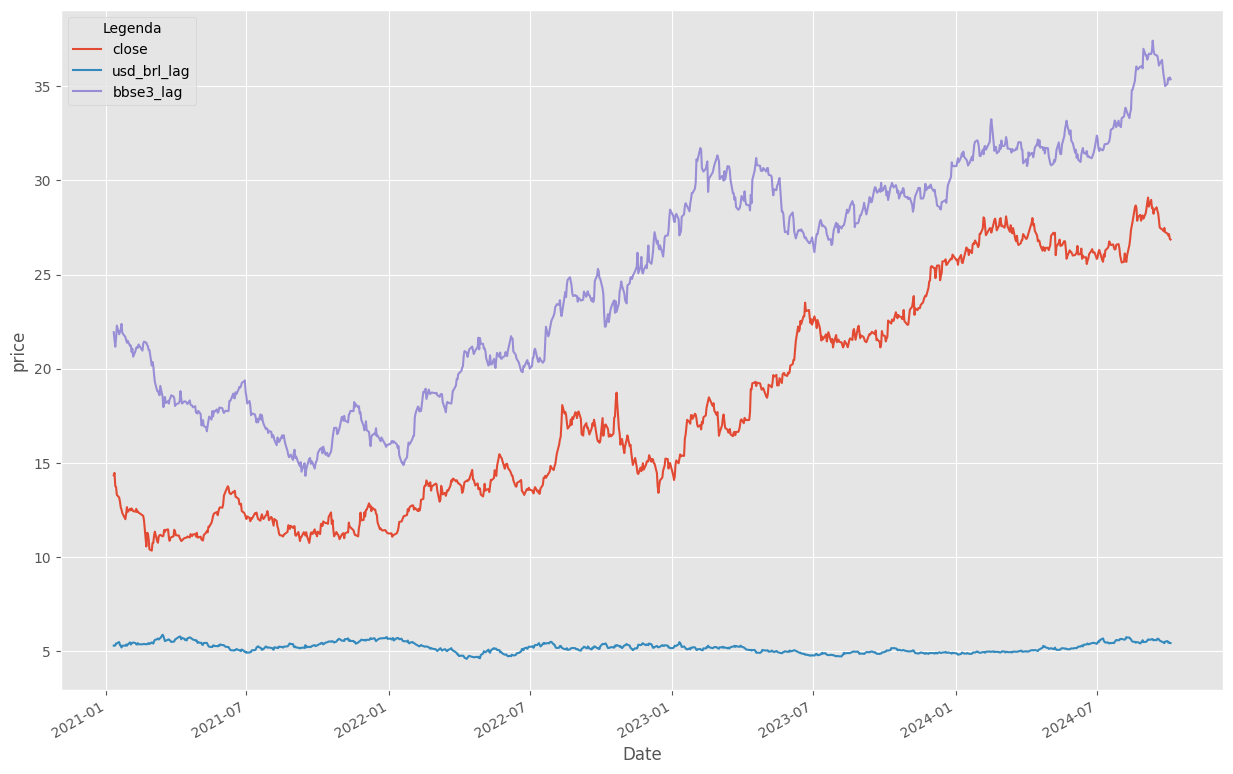

In [38]:
df[['close', 'usd_brl_lag', 'bbse3_lag']].plot(figsize=(15, 10))

plt.xlabel('Date')
plt.ylabel('price')

plt.legend(title='Legenda')
plt.show()

## Decompose

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [40]:
decompose = seasonal_decompose(df['close'].sort_index(ascending=True),
                               model = 'multiplicative',
                               extrapolate_trend = 'freq',
                               period=5)

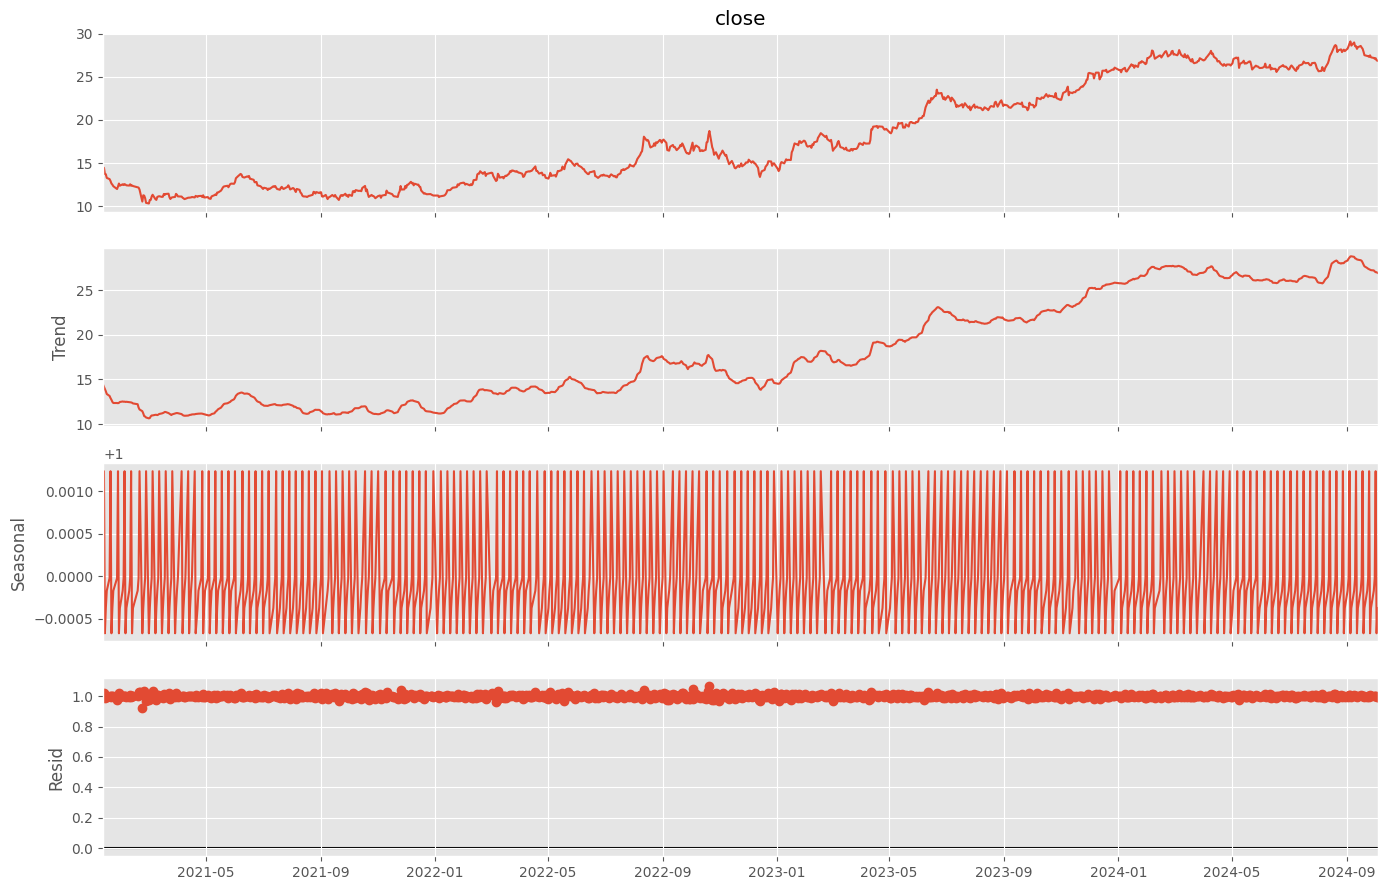

In [41]:
plt.rcParams.update({'figure.figsize': (14,9)})
decompose.plot()
plt.show()

From this decomposition, we can conclude that:

- The stock price is trending upward.
- There's evidence of seasonality in the stock price.
- The stock price has a significant random component, making short-term predictions difficult.

## Autocorrelation

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) Graphs

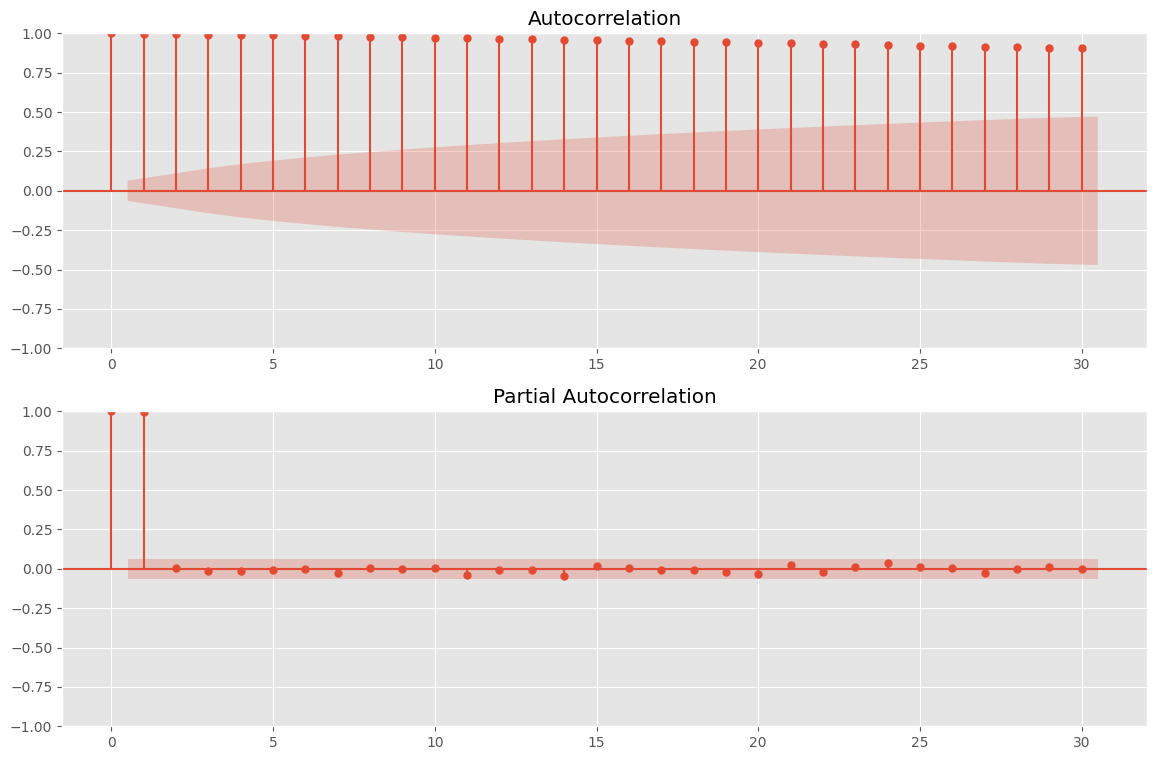

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Plots
plt.rcParams.update({'figure.figsize': (14,9)})

# Plot ACF
plt.subplot(211)
plot_acf(df['close'].sort_index(ascending=True), ax = plt.gca(), lags = 30)

# Plot PACF
plt.subplot(212)
plot_pacf(df['close'].sort_index(ascending=True), ax = plt.gca(), lags = 30, method = 'ywm')
plt.show()

- ACF:
  - Most autocorrelation values are outside the confidence bands, suggesting strong autocorrelation in the series.
  - The lack of decay in the autocorrelations indicates the series may be non-stationary.
- PACF:
  - The partial autocorrelation is high and significant only at lag 1, indicating that most of the autocorrelation is explained by the relationship with the previous value. After lag 1, partial autocorrelations are near zero, suggesting that the relationship with more distant past values is weaker.

## Stationarity

In [43]:
for col in df.columns.tolist():
  print(f'{col}: {adfuller(df[col])[1]}')

close: 0.5912369550715136
bbse3_lag: 0.45394492226502475
usd_brl_lag: 0.06706658564486108
gold_usd_lag: 0.02620827174399514


'close' and 'bbse3_lag' series are not stationary.

'usd_brl_lag' is very close to being stationary.

'gold_usd_lag' is stationary.

Let's transform them.

In [44]:
def estac(x):
  p_value = adfuller(x)[1]
  print(f'{x.name}: {p_value}')

  if p_value > 0.05:
    print('This series is NOT stationary')
  else:
    print('This series is stationary')

### Variable "close"

#### Attempt 1 - Simple transformations

In [45]:
df['close_log'] = np.log(df['close'])
estac(df['close_log'])

close_log: 0.61372897647717
This series is NOT stationary


In [46]:
df['close_box'], _ = boxcox(df['close'])
estac(df['close_box'])

close_box: 0.6144035923728532
This series is NOT stationary


In [47]:
df.drop(['close_log','close_box'], axis=1, inplace=True)

In [48]:
df.head()

,close,bbse3_lag,usd_brl_lag,gold_usd_lag
time,,,,
2024-10-04,26.86,35.37,5.4329,2657.97
2024-10-03,26.90,35.47,5.4375,2670.20
2024-10-02,27.15,35.35,5.4774,2656.82
2024-10-01,27.08,35.42,5.4547,2656.70
2024-09-30,27.18,35.13,5.5364,2628.40


Two simple transformations didn’t even come close to making the variable stationary.

So, instead of trying others like square root or Yeo-Johnson, I decided to try a more robust transformation, differentiation.

#### Attempt 2 - Differentiation

In [49]:
close_log = np.log(df['close'])

In [50]:
close_log.tail()

,close
time,
2021-01-15,2.587764
2021-01-14,2.618855
2021-01-13,2.621766
2021-01-12,2.672078
2021-01-11,2.663053


In [51]:
close_log_diff = close_log - close_log.shift(-1)

In [52]:
close_log_diff.tail()

,close
time,
2021-01-15,-0.031091
2021-01-14,-0.002911
2021-01-13,-0.050312
2021-01-12,0.009025
2021-01-11,NaN


In [53]:
close_log_diff.dropna(inplace=True)
estac(close_log_diff)

close: 8.147456746533344e-30
This series is stationary


### BBSE3

In [54]:
bbs_log = np.log(df['bbse3_lag'])

In [55]:
bbs_log_diff = bbs_log - bbs_log.shift(-1)

In [56]:
bbs_log_diff.tail()

,bbse3_lag
time,
2021-01-15,0.030519
2021-01-14,0.021034
2021-01-13,-0.016398
2021-01-12,-0.019329
2021-01-11,NaN


In [57]:
bbs_log_diff.dropna(inplace=True)
estac(bbs_log_diff)

bbse3_lag: 0.0
This series is stationary


### USD-BRL

In [58]:
usd_log = np.log(df['usd_brl_lag'])

In [59]:
usd_log_diff = usd_log - usd_log.shift(-1)

In [60]:
usd_log_diff.tail()

,usd_brl_lag
time,
2021-01-15,0.001422
2021-01-14,0.017942
2021-01-13,0.005378
2021-01-12,-0.002155
2021-01-11,NaN


In [61]:
usd_log_diff.dropna(inplace=True)
estac(usd_log_diff)

usd_brl_lag: 0.0
This series is stationary


### GOLD_USD

In [62]:
gold_log = np.log(df['gold_usd_lag'])

In [63]:
gold_log_diff = gold_log - gold_log.shift(-1)

In [64]:
gold_log_diff.tail()

,gold_usd_lag
time,
2021-01-15,-0.034167
2021-01-14,-0.003294
2021-01-13,-0.015791
2021-01-12,0.003633
2021-01-11,NaN


In [65]:
gold_log_diff.dropna(inplace=True)
estac(gold_log_diff)

gold_usd_lag: 9.19357306898315e-13
This series is stationary


In [66]:
df.tail()

,close,bbse3_lag,usd_brl_lag,gold_usd_lag
time,,,,
2021-01-15,13.30,22.29,5.4178,1848.26
2021-01-14,13.72,21.62,5.4101,1912.50
2021-01-13,13.76,21.17,5.3139,1918.81
2021-01-12,14.47,21.52,5.2854,1949.35
2021-01-11,14.34,21.94,5.2968,1942.28


### Day & Month

Let's create the variable "day", "month" and apply the differentiation

In [67]:
df['day'] = np.log(df.index.day)
df['month'] = np.log(df.index.month)

In [68]:
day_diff = df['day'] - df['day'].shift(-1)
day_diff.dropna(inplace=True)
estac(day_diff)

day: 0.0
This series is stationary


In [69]:
month_diff = df['month'] - df['month'].shift(-1)
month_diff.dropna(inplace=True)
estac(month_diff)

month: 0.0
This series is stationary


In [70]:
df = pd.concat([bbs_log_diff, close_log_diff, usd_log_diff, gold_log_diff, day_diff, month_diff], axis=1, join='inner')

In [71]:
df.head()

,bbse3_lag,close,usd_brl_lag,gold_usd_lag,day,month
time,,,,,,
2024-10-04,-0.002823,-0.001488,-0.000846,-0.004591,0.287682,0.000000
2024-10-03,0.003389,-0.009251,-0.007311,0.005023,0.405465,0.000000
2024-10-02,-0.001978,0.002582,0.004153,0.000045,0.693147,0.000000
2024-10-01,0.008221,-0.003686,-0.014867,0.010709,-3.401197,0.105361
2024-09-30,0.003422,-0.002572,0.004725,0.002453,0.105361,0.000000


# Preprocessing

In [72]:
# Train and Validation split
val = df[(df.index > '2024-09-29') & (df.index < '2024-10-05')]
train = df[df.index < '2024-09-29']

In [73]:
train.head()

,bbse3_lag,close,usd_brl_lag,gold_usd_lag,day,month
time,,,,,,
2024-09-27,-0.009948,-0.008405,0.015362,0.013624,0.037740,0.0
2024-09-26,-0.006483,0.006572,-0.006411,0.010619,0.039221,0.0
2024-09-25,-0.010343,-0.002926,-0.003893,-0.004040,0.040822,0.0
2024-09-24,-0.012162,-0.000730,-0.005003,-0.005070,0.042560,0.0
2024-09-23,0.005786,-0.003643,-0.009753,0.002357,0.139762,0.0


## Normalizing exogenous variables

In [74]:
# Exogenous variables
exog = ['bbse3_lag', 'usd_brl_lag', 'day', 'month']

In [75]:
y_train = train['close']
y_val = val['close']

In [76]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train[exog])
val_scaled = scaler.transform(val[exog])

In [77]:
train_scaled = pd.DataFrame(train_scaled, columns=exog, index=train.index)
val_scaled = pd.DataFrame(val_scaled, columns=exog, index=val.index)

## Normalizing target variable

In [78]:
scaler_target = MinMaxScaler(feature_range=(0,1))
y_train2 = scaler_target.fit_transform(y_train.to_frame())
y_val2 = scaler_target.transform(y_val.to_frame())

In [79]:
y_train2 = pd.DataFrame(y_train2, index=train.index)
y_val2 = pd.DataFrame(y_val2, index=val.index)

In [80]:
train_scaled.head()

,bbse3_lag,usd_brl_lag,day,month
time,,,,
2024-09-27,0.430943,0.746619,0.688367,0.781896
2024-09-26,0.460244,0.485596,0.688661,0.781896
2024-09-25,0.427602,0.515788,0.688978,0.781896
2024-09-24,0.412215,0.502471,0.689323,0.781896
2024-09-23,0.564027,0.445535,0.708596,0.781896


In [81]:
train_scaled.shape

(928, 4)

# Modeling

## ARIMA

### Train

In [82]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#model_sarimax = SARIMAX(y_train2, exog=train_scaled, order=(3,1,1))
model_sarimax = SARIMAX(y_train2, exog=train_scaled, order=(2,1,3))
#model_sarimax = SARIMAX(y_train2, exog=train_scaled, order=(2,1,3), seasonal_order=(0, 1, 1, 5))
#model_sarimax = SARIMAX(y_train2, order=(2,1,3), seasonal_order=(0, 1, 1, 5))
results_sarimax = model_sarimax.fit()

In [83]:
print(results_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  928
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 933.546
Date:                Fri, 08 Nov 2024   AIC                          -1847.092
Time:                        21:56:51   BIC                          -1798.773
Sample:                             0   HQIC                         -1828.660
                                - 928                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
bbse3_lag      -0.0240      0.026     -0.907      0.364      -0.076       0.028
usd_brl_lag     0.0234      0.026      0.915      0.360      -0.027       0.073
day             0.0085      0.023      0.379    

In [84]:
res = results_sarimax.resid

- The model seems to have two issues with the residuals: heteroscedasticity and non-normality.
- Let's plot the residuals to better understand the situation.

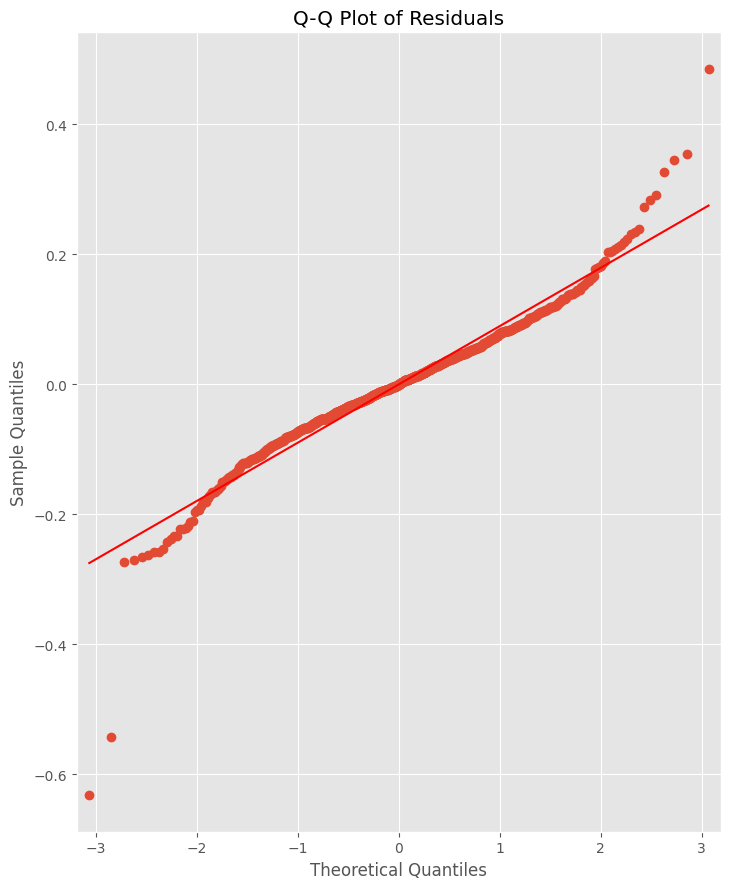

In [85]:
plt.subplot(1, 2, 2)
sm.qqplot(res, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

As we can see, the non-normality of the residuals is due to a small number of outliers. Most of the residuals are close to the line.

### Validation

In [86]:
train_scaled.shape, val_scaled.shape

((928, 4), (5, 4))

In [87]:
val_pred_sarimax = results_sarimax.predict(start=len(train_scaled), end=len(train_scaled)+len(val_scaled)-1, exog=val_scaled)
val_pred_sarimax.index = val_scaled.index
print(val_pred_sarimax)

time
2024-10-04    0.647020
2024-10-03    0.610501
2024-10-02    0.646229
2024-10-01    0.619937
2024-09-30    0.623956
Name: predicted_mean, dtype: float64


In [88]:
# Calculating metrics between the predictions and the actual values
mae_val = mean_absolute_error(y_val2, val_pred_sarimax)
mse_val = mean_squared_error(y_val2, val_pred_sarimax)
rmse = sqrt(mean_squared_error(y_val2, val_pred_sarimax))

print(f'Mean Absolute Error (MAE) with training data: {mae_val}')
print(f'Mean Squared Error (MSE) with training data: {mse_val}')
print(f'RMSE with training data: {rmse}')

Mean Absolute Error (MAE) with training data: 0.016638622796363235
Mean Squared Error (MSE) with training data: 0.00037448077467673737
RMSE with training data: 0.019351505747014556


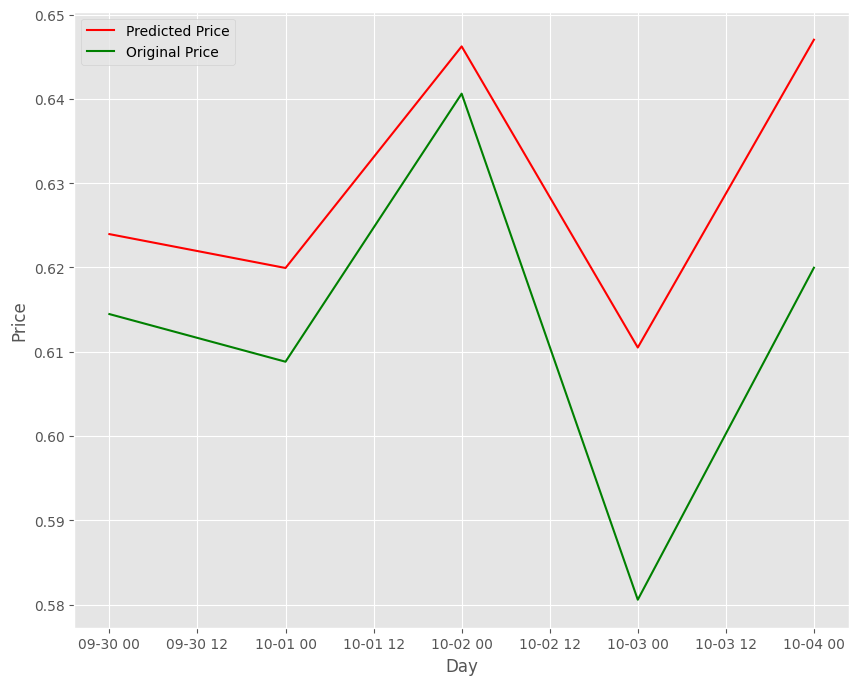

In [89]:
plt.figure(figsize=(10,8))
plt.plot(val_pred_sarimax, 'r', label = 'Predicted Price')
plt.plot(y_val2, 'g', label = 'Original Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

## Prophet

### Preparing the Datasets

In [90]:
train_prophet = train_scaled.copy()
train_prophet['y'] = y_train2
train_prophet.sort_index(ascending=True, inplace=True)
train_prophet.reset_index(inplace=True)

In [91]:
train_prophet.rename(columns={'time': 'ds'}, inplace=True)

In [92]:
train_prophet

,ds,bbse3_lag,usd_brl_lag,day,month,y
0,2021-01-12,0.351590,0.536625,0.698136,0.781896,0.673318
1,2021-01-13,0.376383,0.626927,0.696755,0.781896,0.372206
2,2021-01-14,0.693004,0.777550,0.695578,0.781896,0.612747
3,2021-01-15,0.773239,0.579506,0.694564,0.781896,0.469747
4,2021-01-18,0.338697,0.718982,0.717034,0.781896,0.573820
...,...,...,...,...,...,...
923,2024-09-23,0.564027,0.445535,0.708596,0.781896,0.609034
924,2024-09-24,0.412215,0.502471,0.689323,0.781896,0.623815
925,2024-09-25,0.427602,0.515788,0.688978,0.781896,0.612672
926,2024-09-26,0.460244,0.485596,0.688661,0.781896,0.660870


In [93]:
val_prophet = val_scaled.copy()
val_prophet['y'] = y_val2
val_prophet.sort_index(ascending=True, inplace=True)
val_prophet.reset_index(inplace=True)
val_prophet.rename(columns={'time': 'ds'}, inplace=True)

In [94]:
val_prophet

,ds,bbse3_lag,usd_brl_lag,day,month,y
0,2024-09-30,0.544029,0.619106,0.701775,0.781896,0.614468
1,2024-10-01,0.584626,0.384222,0.006501,0.815048,0.608816
2,2024-10-02,0.498353,0.612243,0.818320,0.781896,0.640621
3,2024-10-03,0.543751,0.474805,0.761279,0.781896,0.580576
4,2024-10-04,0.491205,0.552309,0.737925,0.781896,0.619969


### Train

In [95]:
model = Prophet(daily_seasonality=False, changepoint_range=0.9)

In [96]:
for col in exog:
  model.add_regressor(col)

In [97]:
model.add_country_holidays(country_name='BR')
model.add_seasonality(name='daily', period=5, fourier_order=5)

In [98]:
model.fit(train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_8ci_hrt/ljpfo848.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_8ci_hrt/ca9djt3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35708', 'data', 'file=/tmp/tmp_8ci_hrt/ljpfo848.json', 'init=/tmp/tmp_8ci_hrt/ca9djt3c.json', 'output', 'file=/tmp/tmp_8ci_hrt/prophet_modelp5e3hpa5/prophet_model-20241108215652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:56:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:56:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [99]:
future = model.make_future_dataframe(periods=0)  # 0 = predict the same data set
for col in exog:
  future[col] = train_prophet[col].values

pred = model.predict(future)

In [100]:
# Adding the predictions and calculating the residuals
train_prophet['y_pred'] = pred['yhat']
train_prophet['residuals'] = train_prophet['y'] - train_prophet['y_pred']

In [101]:
train_prophet

,ds,bbse3_lag,usd_brl_lag,day,month,y,y_pred,residuals
0,2021-01-12,0.351590,0.536625,0.698136,0.781896,0.673318,0.634643,0.038675
1,2021-01-13,0.376383,0.626927,0.696755,0.781896,0.372206,0.639474,-0.267268
2,2021-01-14,0.693004,0.777550,0.695578,0.781896,0.612747,0.638110,-0.025363
3,2021-01-15,0.773239,0.579506,0.694564,0.781896,0.469747,0.630269,-0.160522
4,2021-01-18,0.338697,0.718982,0.717034,0.781896,0.573820,0.636314,-0.062494
...,...,...,...,...,...,...,...,...
923,2024-09-23,0.564027,0.445535,0.708596,0.781896,0.609034,0.617401,-0.008367
924,2024-09-24,0.412215,0.502471,0.689323,0.781896,0.623815,0.629326,-0.005511
925,2024-09-25,0.427602,0.515788,0.688978,0.781896,0.612672,0.637239,-0.024568
926,2024-09-26,0.460244,0.485596,0.688661,0.781896,0.660870,0.627341,0.033529


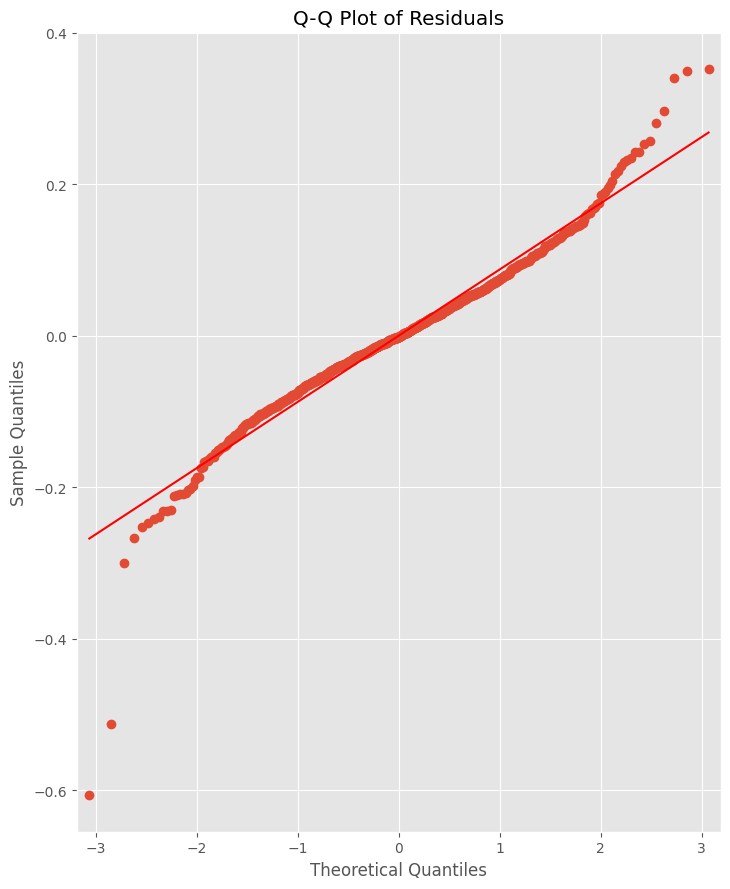

In [102]:
plt.subplot(1, 2, 2)
sm.qqplot(train_prophet['residuals'], line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

### Validation

In [103]:
df_future = pd.DataFrame({'ds': pd.date_range(start=val_prophet['ds'].iloc[0],
                                             end=val_prophet['ds'].iloc[-1],
                                             freq='D')})
df_future

,ds
0,2024-09-30
1,2024-10-01
2,2024-10-02
3,2024-10-03
4,2024-10-04


In [104]:
for col in exog:
  df_future[col] = val_prophet[col].values

df_future

,ds,bbse3_lag,usd_brl_lag,day,month
0,2024-09-30,0.544029,0.619106,0.701775,0.781896
1,2024-10-01,0.584626,0.384222,0.006501,0.815048
2,2024-10-02,0.498353,0.612243,0.818320,0.781896
3,2024-10-03,0.543751,0.474805,0.761279,0.781896
4,2024-10-04,0.491205,0.552309,0.737925,0.781896


In [105]:
forecast = model.predict(df_future)

In [106]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2024-09-30,0.644868,0.537002,0.752155
1,2024-10-01,0.632720,0.519104,0.740106
2,2024-10-02,0.644593,0.525026,0.756922
3,2024-10-03,0.637906,0.524561,0.743061
4,2024-10-04,0.651923,0.540483,0.755039


In [107]:
val_pred_prophet = forecast.set_index('ds')

In [108]:
val_pred_prophet = val_pred_prophet['yhat'].sort_index(ascending=False)

In [109]:
# Calculating metrics between the predictions and the actual values
mae_val = mean_absolute_error(y_val2, val_pred_prophet)
mse_val = mean_squared_error(y_val2, val_pred_prophet)
rmse = sqrt(mean_squared_error(y_val2, val_pred_prophet))

print(f'Mean Absolute Error (MAE) with training data: {mae_val}')
print(f'Mean Squared Error (MSE) with training data: {mse_val}')
print(f'RMSE with training data: {rmse}')

Mean Absolute Error (MAE) with training data: 0.029511942806996982
Mean Squared Error (MSE) with training data: 0.0011638139946506699
RMSE with training data: 0.03411471815288337


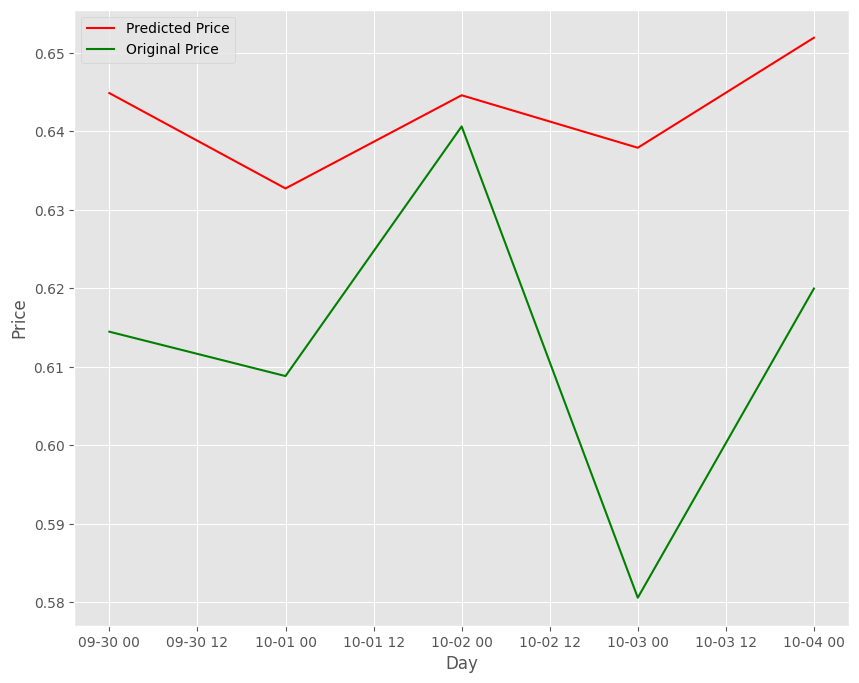

In [110]:
plt.figure(figsize=(10,8))
plt.plot(val_pred_prophet, 'r', label = 'Predicted Price')
plt.plot(y_val2, 'g', label = 'Original Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()